# 第 12 周（第一部分）
3220190783 陈子康

GitHub 地址：https://github.com/czyczk/data-mining-course

本部分作业使用 Wine Benchmarks 数据集。

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.xgbod import XGBOD
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
# Lib config
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

## 1 Wine benchmarks
### 1.1 导入数据集并合并
选择数据集中的前 20 个 .csv 文件（约 8 万条数据）作为训练集，后 1/4 作为测试集。

即 0001 到 0020 为训练集，1261 到 1680（最后一个）为测试集。

In [3]:
range_train = range(1, 21)
range_test = range(1261, 1681)

# Wine benchmarks dataset
data_wine_train_list = []
try:    
    for i in range_train:
        data_wine_train_list.append(pd.read_csv('../Datasets/Wine_Benchmarks/wine/benchmarks/wine_benchmark_{:04d}.csv'.format(i)))
except FileNotFoundError:
    # Some files (e.g. whose indexes are in range of [0481, 0600]) are missing. Just skip them.
    pass

data_wine_test_list = []
try:    
    for i in range_test:
        data_wine_test_list.append(pd.read_csv('../Datasets/Wine_Benchmarks/wine/benchmarks/wine_benchmark_{:04d}.csv'.format(i)))
except FileNotFoundError:
    pass


In [4]:
data_wine_train_concatted = None
try:
    data_wine_train_concatted = pd.concat(data_wine_train_list, ignore_index = True, verify_integrity = True, sort = False)
except ValueError as e:
    print('ValueError:', e)
# data_crime_concatted.reset_index(drop = True, inplace = True)

data_wine_test_concatted = None
try:
    data_wine_test_concatted = pd.concat(data_wine_test_list, ignore_index = True, verify_integrity = True, sort = False)
except ValueError as e:
    print('ValueError:', e)

为数据集标记异常，若在 `ground.truth` 标签为 "anomaly"，则计为 1，否则计为 0。

In [5]:
def derive_is_anomaly_col(df):
    if df['ground.truth'] == 'anomaly':
        return 1
    else:
        return 0

In [6]:
data_wine_train_concatted['is.anomaly'] = data_wine_train_concatted.apply(derive_is_anomaly_col, axis = 1)
data_wine_train_x = data_wine_train_concatted.loc[:, 'fixed.acidity':'alcohol']
data_wine_train_y = data_wine_train_concatted.loc[:, 'is.anomaly']

In [7]:
data_wine_test_concatted['is.anomaly'] = data_wine_test_concatted.apply(derive_is_anomaly_col, axis = 1)
data_wine_test_x = data_wine_test_concatted.loc[:, 'fixed.acidity':'alcohol']
data_wine_test_y = data_wine_test_concatted.loc[:, 'is.anomaly']

选取一部分作为试训练集，在正式报告中忽略以下部分。

In [8]:
lite_scope = 100
data_wine_train_x_lite = data_wine_train_x.loc[0:lite_scope, :]
data_wine_train_y_lite = data_wine_train_y.loc[0:lite_scope]

### 1.2 XGBOD

In [9]:
clf_xgbod = XGBOD(random_state = 42)
clf_xgbod.fit(data_wine_train_x, data_wine_train_y)

C:\tools\Anaconda3\lib\site-packages\pyod\models\base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly 

[00:59:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
  radius=1.0), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=1, p=...x_features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=42,
    verbose=0)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
   nthread=None, objective='binary:logistic', random_state=42, reg_alpha=0,
   reg_lambda=1, scale_pos_weight=1, silent=True,
   standardization_flag_list=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, 

In [10]:
xgbod_train_y_pred = clf_xgbod.labels_
xgbod_train_y_scores = clf_xgbod.decision_scores_

计算在**训练集**上的**准确率**。

In [11]:
def calculate_accuracy(ground_truths, predictions):
    '''
    The result will be in the order of "true positive", "false positive", "false negative", "true negative".
    '''
    num_true_positive = 0
    num_false_positive = 0
    num_false_negative = 0
    num_true_negative = 0

    for i in range(len(predictions)):
        if predictions[i] == 1 and ground_truths[i] == 1:
            num_true_positive += 1
        elif predictions[i] == 1 and ground_truths[i] == 0:
            num_false_positive += 1
        elif predictions[i] == 0 and ground_truths[i] == 1:
            num_false_negative += 1
        else:
            num_true_negative += 1
    
    return (num_true_positive, num_false_positive, num_false_negative, num_true_negative)

In [12]:
xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative = calculate_accuracy(data_wine_train_y, xgbod_train_y_pred)

In [13]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative))
precision = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_positive)
recall = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_negative)
accuracy = (xgbod_num_true_positive + xgbod_num_true_negative) / len(xgbod_train_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('XGBOD', data_wine_train_y, xgbod_train_y_scores)

TP: 18649
FP: 5636
FN: 8362
TN: 41413
Percision: 0.7679225859584106
Recall: 0.6904224204953537
Accuracy: 0.8109910883067782
F1 Score: 0.7271132252027449
XGBOD ROC:0.8887, precision @ rank n:0.7418


使用**测试集**预测并计算在其上的**准确率**。

In [14]:
xgbod_test_y_pred = clf_xgbod.predict(data_wine_test_x)
xgbod_test_y_scores = clf_xgbod.decision_function(data_wine_test_x)

In [15]:
xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative = calculate_accuracy(data_wine_test_y, xgbod_test_y_pred)

In [16]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(xgbod_num_true_positive, xgbod_num_false_positive, xgbod_num_false_negative, xgbod_num_true_negative))
precision = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_positive)
recall = xgbod_num_true_positive / (xgbod_num_true_positive + xgbod_num_false_negative)
accuracy = (xgbod_num_true_positive + xgbod_num_true_negative) / len(xgbod_test_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('XGBOD', data_wine_test_y, xgbod_test_y_scores)

TP: 14840
FP: 56268
FN: 7378
TN: 365100
Percision: 0.20869663047758338
Recall: 0.6679269061121613
Accuracy: 0.8565193671576651
F1 Score: 0.31802498767760323
XGBOD ROC:0.8699, precision @ rank n:0.3533


使用 **T-SNE 将高维数据降维至 2 维**，以便可视化展示。

In [19]:
# TSNE (prep for visualization)
tsne = TSNE(n_components = 2, n_jobs = 8)
tsne_train_x = tsne.fit_transform(data_wine_train_x)
tsne_test_x = tsne.fit_transform(data_wine_test_x)

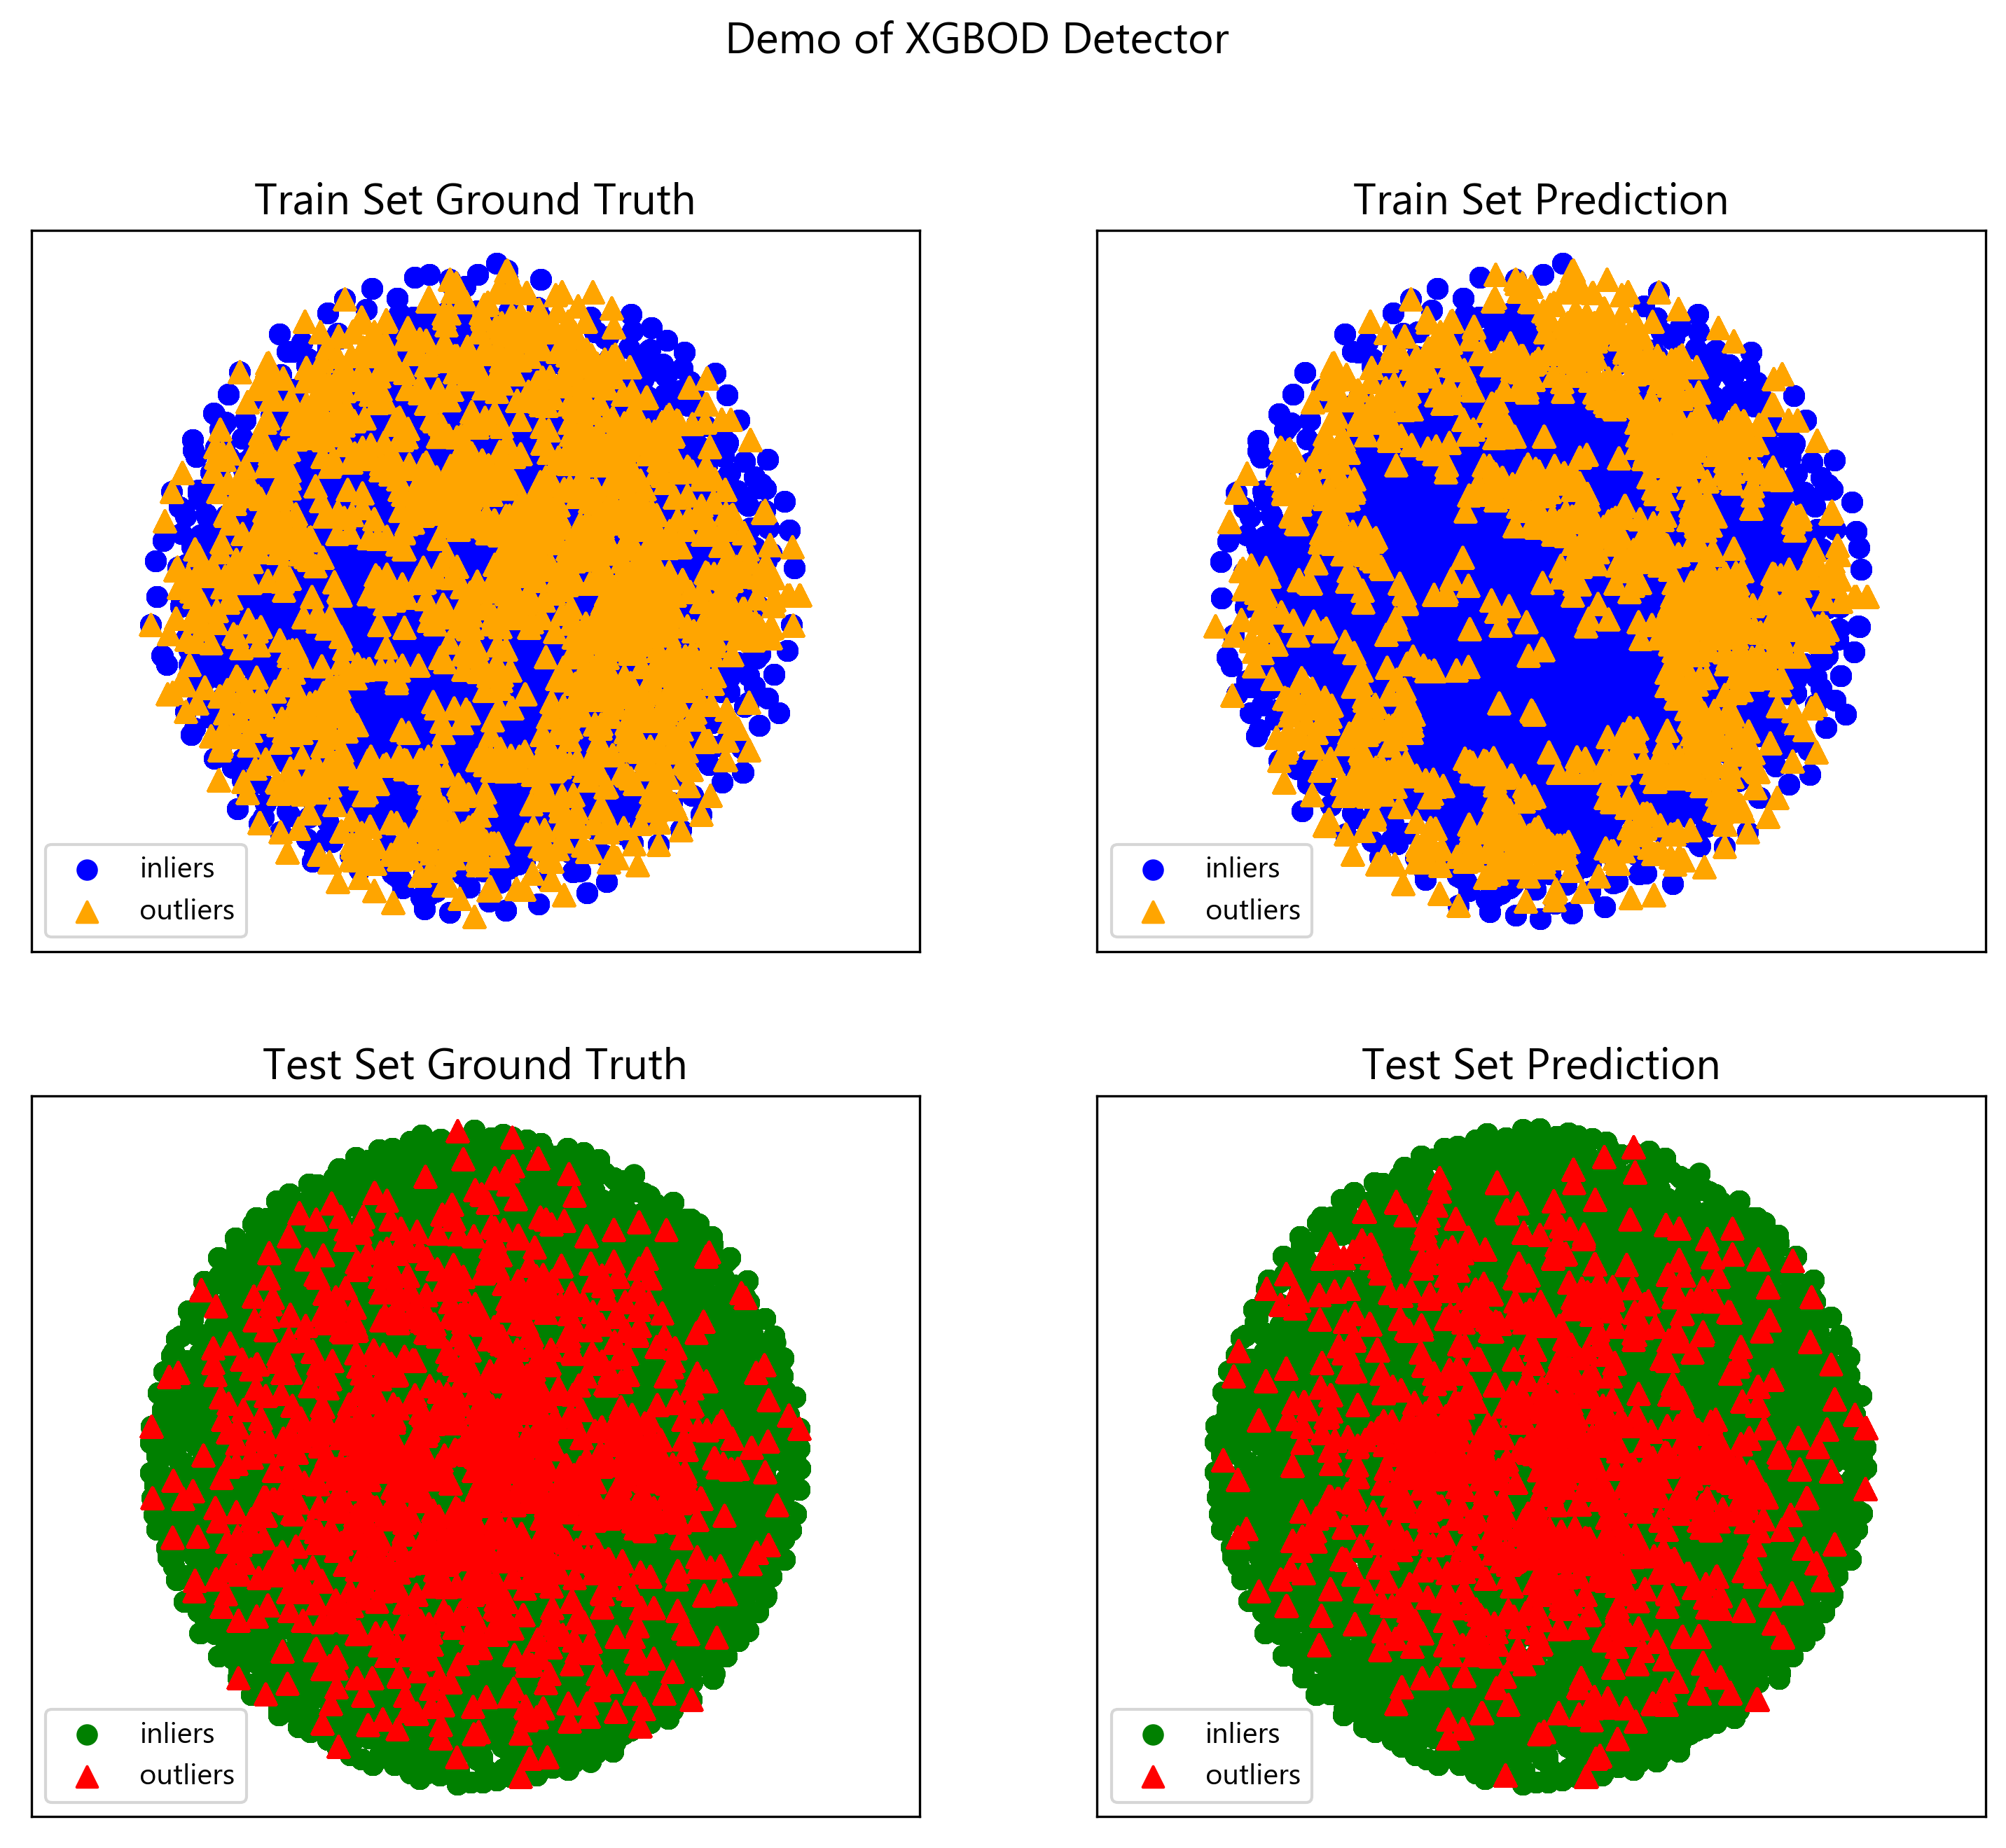

In [20]:
# Visualization
visualize('XGBOD', tsne_train_x, data_wine_train_y, tsne_test_x, data_wine_test_y, xgbod_train_y_pred,
xgbod_test_y_pred, show_figure = True, save_figure = False)

### 1.3 KNN

In [21]:
# train kNN detector
clf_knn = KNN()
clf_knn.fit(data_wine_train_x)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [22]:
knn_train_y_pred = clf_knn.labels_
knn_train_y_scores = clf_knn.decision_scores_

计算在**训练集**上的**准确率**。

In [23]:
knn_num_true_positive, knn_num_false_positive, knn_num_false_negative, knn_num_true_negative = calculate_accuracy(data_wine_train_y, knn_train_y_pred)

In [24]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(knn_num_true_positive, knn_num_false_positive, knn_num_false_negative, knn_num_true_negative))
precision = knn_num_true_positive / (knn_num_true_positive + knn_num_false_positive)
recall = knn_num_true_positive / (knn_num_true_positive + knn_num_false_negative)
accuracy = (knn_num_true_positive + knn_num_true_negative) / len(knn_train_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('kNN', data_wine_train_y, knn_train_y_scores)

TP: 39
FP: 62
FN: 26972
TN: 46987
Percision: 0.38613861386138615
Recall: 0.0014438562067305913
Accuracy: 0.6349716446124763
F1 Score: 0.002876954853939215
kNN ROC:0.5001, precision @ rank n:0.3861


使用**测试集**预测并计算在其上的**准确率**。

In [25]:
knn_test_y_pred = clf_knn.predict(data_wine_test_x)
knn_test_y_scores = clf_knn.decision_function(data_wine_test_x)

In [26]:
knn_num_true_positive, knn_num_false_positive, knn_num_false_negative, knn_num_true_negative = calculate_accuracy(data_wine_test_y, knn_test_y_pred)

In [27]:
print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(knn_num_true_positive, knn_num_false_positive, knn_num_false_negative, knn_num_true_negative))
precision = knn_num_true_positive / (knn_num_true_positive + knn_num_false_positive)
recall = knn_num_true_positive / (knn_num_true_positive + knn_num_false_negative)
accuracy = (knn_num_true_positive + knn_num_true_negative) / len(knn_test_y_pred)
f1_score = 2 * recall * precision / (recall + precision)
print('Percision: {}\nRecall: {}'.format(precision, recall))
print('Accuracy: {}'.format(accuracy))
print('F1 Score: {}'.format(f1_score))
evaluate_print('kNN', data_wine_test_y, knn_test_y_scores)

TP: 7
FP: 272
FN: 22211
TN: 421096
Percision: 0.025089605734767026
Recall: 0.000315059861373661
Accuracy: 0.9493153526035538
F1 Score: 0.0006223051962483887
kNN ROC:0.4998, precision @ rank n:0.0251


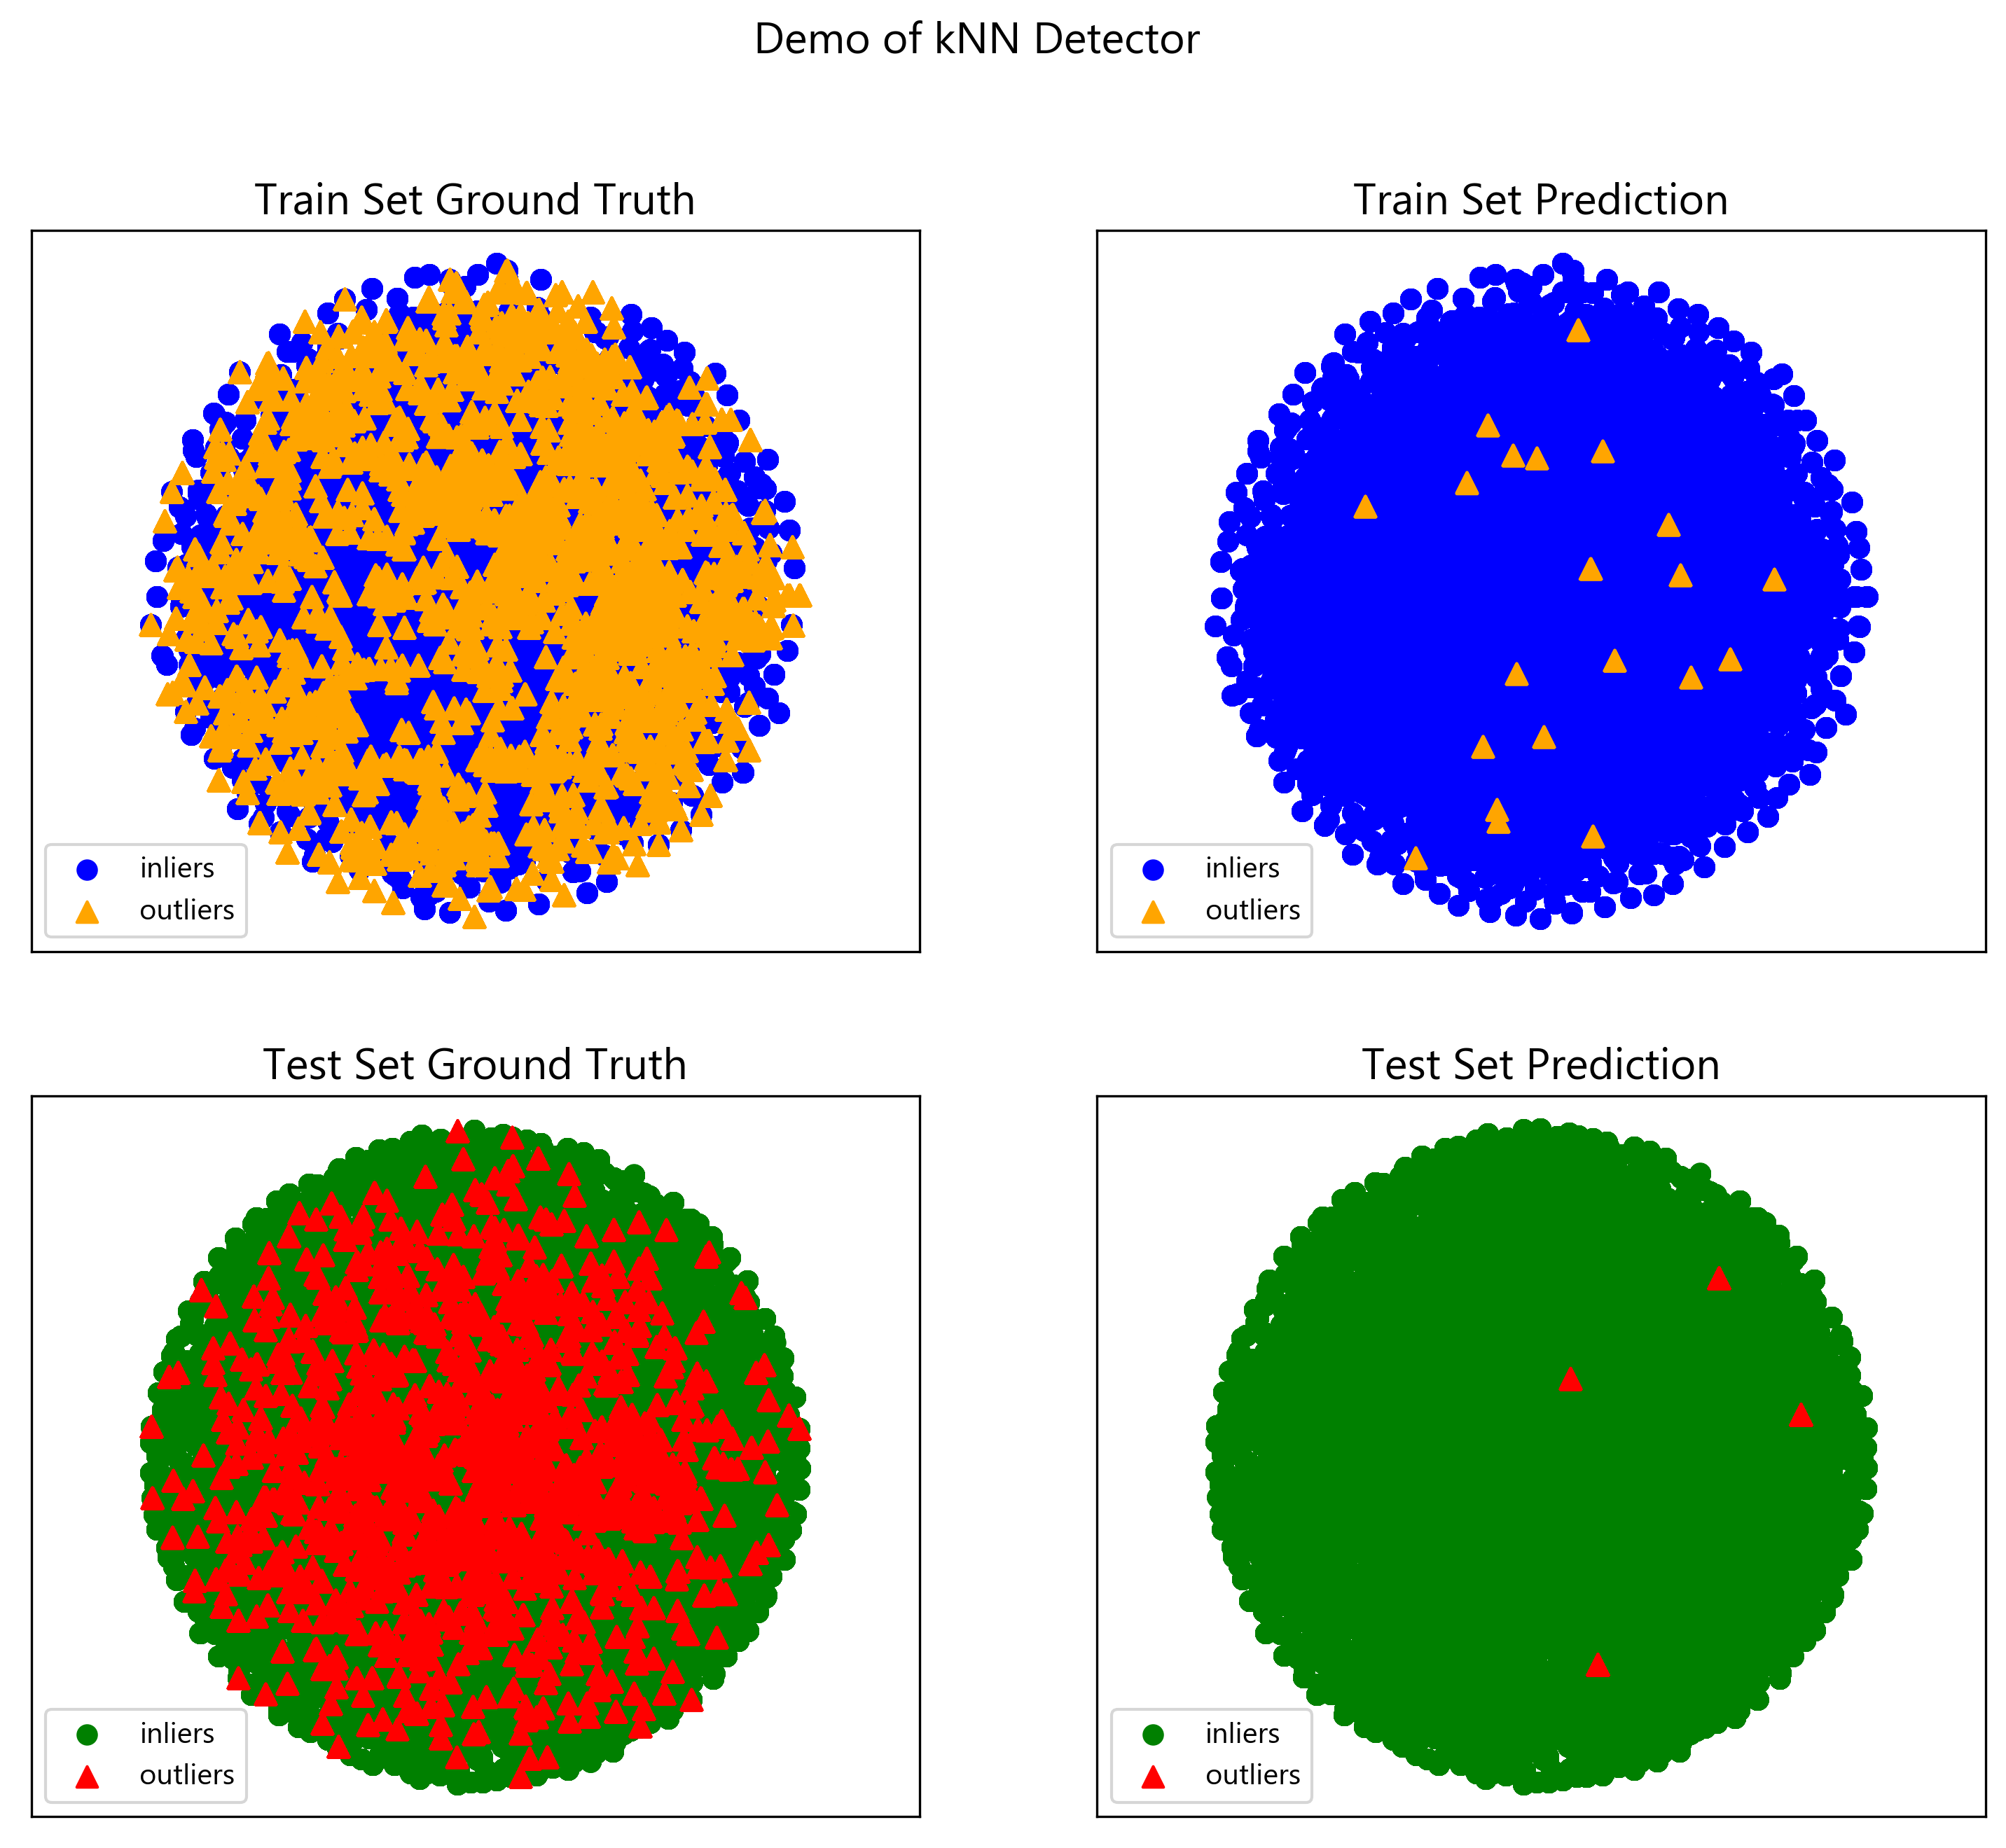

In [28]:
# Visualization
visualize('kNN', tsne_train_x, data_wine_train_y, tsne_test_x, data_wine_test_y, knn_train_y_pred,
knn_test_y_pred, show_figure = True, save_figure = False)

### 1.4 总结
使用了 XGBOD 和 kNN 两种方法检测异常值，其中前者为监督方法，后者为非监督方法。

从两种模型在测试集上分别进行预测得到的结果中可以看出，

XGBOD 的 accuracy 约为 0.86，F1 score 约为 0.32，ROC 约为 0.87；

kNN 的 accuracy 约为 0.03，F1 score 约为 0.0006，ROC 约为 0.50；

XGBOD 在这些值方面均优于 kNN，原因可能因为前者利用了数据中的标签信息，有助于提高其预测性能。